# TASK 1


| Team Member | Date |
| :--: | :--: |
|Sushan Zhao, Xiaotian Li| 04/04/2022 |


## 1. Introduction

Given a set of stocks (in our case, e.g., Google), when exploring their volumes at opening and closing, we noticed that there exists some jumps every 5/10 minutes. In this notebook, we try to figure out whether this phenomenon is common in the universe of **S&P 500**. Also, we tried to recognize those jumps. We choose year 2021 as our time window.

## 2. Experiment

Note that our **data source** is WRDS.

A little note before analysis: it's almost always better to use relative path than absolute path. For usage like `'./'`, one dot means the current working directory, you can check it by:

In [ ]:
import os
os.getcwd() # get current working directory

For usage like `'../'`, the two dots means the parent directory. For example, assume your current working folder is `Folder2` and your folder structure is `'/Folder1/Folder2/'`, then `'./'` represents `'/Folder2/'`; `'../'` represents `/Folder1/`.

The working directory usually is the path where this .ipynb/.py file at.

### 2.1 Data

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Read in the data and include the basic information:

In [88]:
# the parse_dates parameter makes the dtype of the corresponding columns to be datetime64[ns],
# if two columns were provided, they can be automatically concatenated 
intraday_data = pd.read_csv('../data/SP500_intraday_2021.csv') 
daily_data = pd.read_csv('../data/SP500_daily_2021.csv')

In [89]:
intraday_data.shape, daily_data.shape

((62274970, 5), (18900, 8))

In [90]:
intraday_data.head()

,date,time,sym_root,sym_suffix,size
0,2021-01-04,04:00:00,AAL,NaN,5487.0
1,2021-01-04,04:00:00,AAPL,NaN,26666.0
2,2021-01-04,04:00:00,ABBV,NaN,122.0
3,2021-01-04,04:00:00,ACN,NaN,22.0
4,2021-01-04,04:00:00,ADBE,NaN,10.0


In [91]:
daily_data.head()

,DATE,SYM_ROOT,symbol,CSize,OSize,total_vol_m,total_vol_b,total_vol_a
0,2021-01-04,ADBE,ADBE,428050.0,51735.0,3370248.0,7383.0,235908.0
1,2021-01-04,ADI,ADI,417462.0,23304.0,2396833.0,5064.0,95352.0
2,2021-01-04,ADP,ADP,388601.0,29201.0,1919053.0,1144.0,346848.0
3,2021-01-04,ADSK,ADSK,176577.0,23054.0,1268950.0,8092.0,130183.0
4,2021-01-04,AEP,AEP,678559.0,25175.0,2679832.0,907.0,552394.0


As we can see, there are several `NaN`s in `intraday_data`. We first replace these `NaN` with empty string, then we concatenate `sym_root` and `sym_suffix` to get a complete column of symbols.

In [92]:
intraday_data.fillna('', inplace=True)
intraday_data['symbol'] = intraday_data['sym_root'] + intraday_data['sym_suffix']

Do a filtering: only choose stocks that are in QQQ.

In [93]:
qqq = pd.read_csv('../data/qqq_symbol.csv')

intraday_data = intraday_data[intraday_data.symbol.isin(qqq.symbol)]
daily_data = daily_data[daily_data.symbol.isin(qqq.symbol)]

List the stocks contained in `intraday_data`:

In [95]:
intraday_data.symbol.unique()

array(['ADBE', 'AEP', 'AMD', 'AMGN', 'AMZN', 'ATVI', 'AVGO', 'BIIB',
       'BKNG', 'CSCO', 'FB', 'GILD', 'GOOGL', 'GOOG', 'ILMN', 'INTC',
       'KHC', 'LRCX', 'MRNA', 'MSFT', 'NFLX', 'NVDA', 'PYPL', 'QCOM',
       'REGN', 'SBUX', 'SWKS', 'TSLA', 'WBA', 'MU', 'TXN', 'AMAT', 'EBAY',
       'FISV', 'VRSK', 'PAYX', 'PEP', 'DXCM', 'ADSK', 'MTCH', 'ADI',
       'HON', 'COST', 'EA', 'VRTX', 'CSX', 'TMUS', 'FAST', 'ORLY', 'ISRG',
       'MCHP', 'XEL', 'MAR', 'ALGN', 'NXPI', 'CDNS', 'ADP', 'IDXX', 'EXC',
       'INTU', 'CPRT', 'DLTR', 'CHTR', 'ROST', 'MNST', 'CTSH', 'FTNT',
       'KLAC', 'MDLZ', 'SNPS', 'ANSS', 'PCAR', 'ODFL', 'VRSN', 'CTAS'],
      dtype=object)

In [23]:
intraday_data.date = pd.to_datetime(intraday_data.date)
intraday_data.time = pd.to_timedelta(intraday_data.time)
intraday_data['datetime'] = intraday_data['date'] + intraday_data['time']

daily_data.DATE = pd.to_datetime(daily_data.DATE)

In [34]:
intraday_data.reset_index(drop=True, inplace=True)
daily_data.reset_index(drop=True, inplace=True)

Merge these two data tables:

In [37]:
df = intraday_data.merge(daily_data, how='left', left_on=['date', 'symbol'], right_on=['DATE', 'symbol'])

In [39]:
df.columns

Index(['date', 'time', 'sym_root', 'sym_suffix', 'size', 'symbol', 'datetime',
       'DATE', 'SYM_ROOT', 'CSize', 'OSize', 'total_vol_m', 'total_vol_b',
       'total_vol_a'],
      dtype='object')

Select those columns that we need:

In [40]:
df = df[['date', 'time', 'datetime', 'symbol', 'size', 'total_vol_m']]
df['%_vol'] = df['size'] / df['total_vol_m']

df.set_index('datetime', inplace=True)
df = df.between_time('09:30:00', '16:00:00').copy()

In [48]:
df.head()

,date,time,symbol,size,total_vol_m,%_vol
datetime,,,,,,
2021-01-04 09:30:00,2021-01-04,0 days 09:30:00,ADBE,140093.0,3370248.0,0.041568
2021-01-04 09:30:00,2021-01-04,0 days 09:30:00,ADI,67872.0,2396833.0,0.028317
2021-01-04 09:30:00,2021-01-04,0 days 09:30:00,ADP,76958.0,1919053.0,0.040102
2021-01-04 09:30:00,2021-01-04,0 days 09:30:00,ADSK,78494.0,1268950.0,0.061857
2021-01-04 09:30:00,2021-01-04,0 days 09:30:00,AEP,60049.0,2679832.0,0.022408


In [49]:
#df.to_csv('../data/QQQ_2021_open_close.csv', index=False)

### 2.2 An example: Google

We use Google stock as an example.

In [53]:
google = df[df.symbol.isin(['GOOGL'])]
google.head()

,date,time,symbol,size,total_vol_m,%_vol
datetime,,,,,,
2021-01-04 09:30:00,2021-01-04,0 days 09:30:00,GOOGL,68842.0,1720933.0,0.040003
2021-01-04 09:31:00,2021-01-04,0 days 09:31:00,GOOGL,7892.0,1720933.0,0.004586
2021-01-04 09:32:00,2021-01-04,0 days 09:32:00,GOOGL,4732.0,1720933.0,0.002750
2021-01-04 09:33:00,2021-01-04,0 days 09:33:00,GOOGL,3836.0,1720933.0,0.002229
2021-01-04 09:34:00,2021-01-04,0 days 09:34:00,GOOGL,5157.0,1720933.0,0.002997


Opening:

<AxesSubplot:title={'center':'Google volume for opening 30 mins'}, xlabel='datetime'>

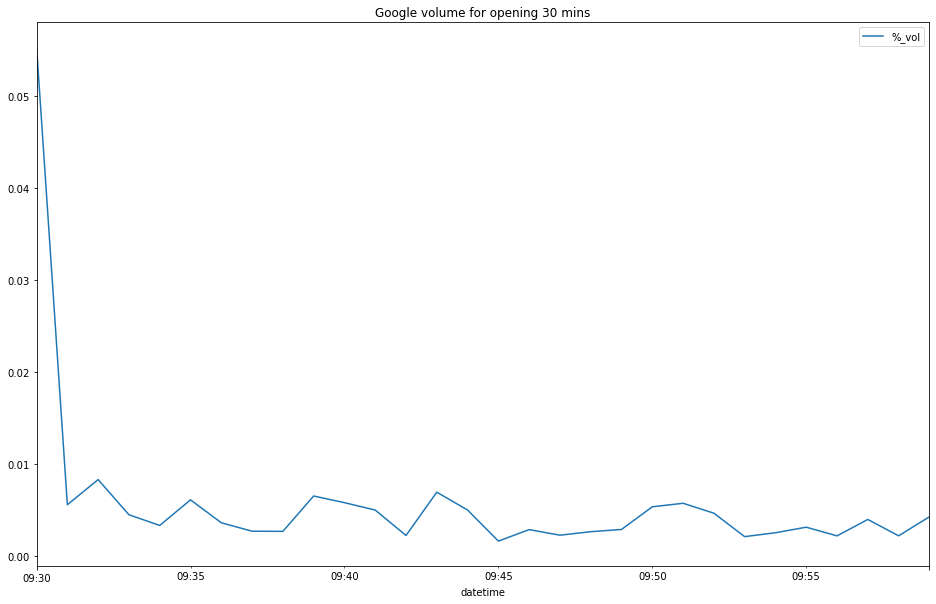

In [141]:
filter = google.date.isin(['2021-02-11']) & (google.time < pd.Timedelta('10:00:00'))
google[filter][['%_vol']].plot(figsize=(16, 10), title='Google volume of opening 30 mins')

Closing:

In [145]:
google.date

datetime
2021-01-04 09:30:00   2021-01-04
2021-01-04 09:31:00   2021-01-04
2021-01-04 09:32:00   2021-01-04
2021-01-04 09:33:00   2021-01-04
2021-01-04 09:34:00   2021-01-04
                         ...    
2021-12-31 15:56:00   2021-12-31
2021-12-31 15:57:00   2021-12-31
2021-12-31 15:58:00   2021-12-31
2021-12-31 15:59:00   2021-12-31
2021-12-31 16:00:00   2021-12-31
Name: date, Length: 98131, dtype: datetime64[ns]

<AxesSubplot:title={'center':'Google volume of closing 30 mins'}, xlabel='datetime'>

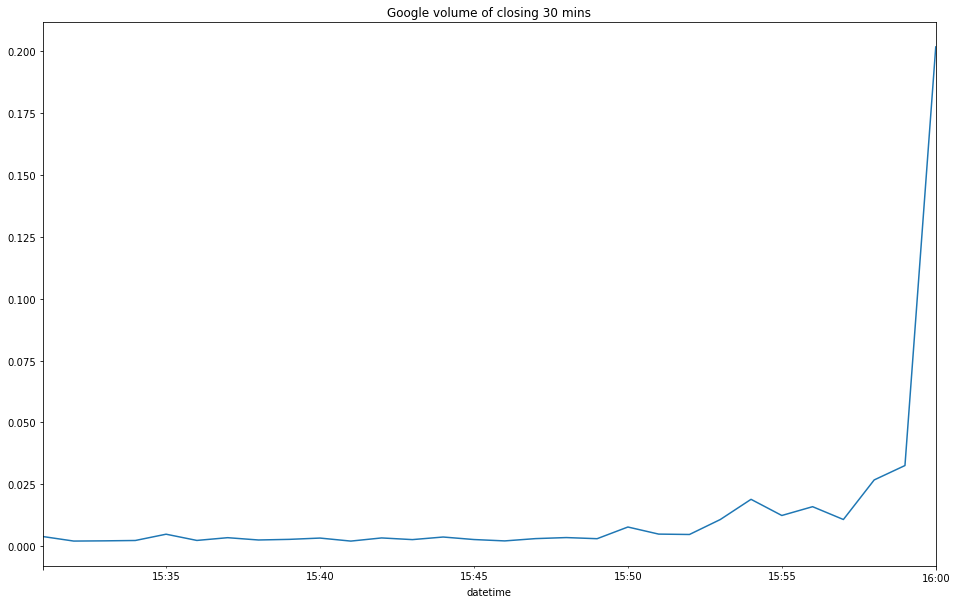

In [142]:
filter = google.date.isin(['2021-01-14']) & (google.time > pd.Timedelta('15:30:00'))
google[filter]['%_vol'].plot(figsize=(16, 10), title='Google volume of closing 30 mins')

<AxesSubplot:xlabel='datetime'>

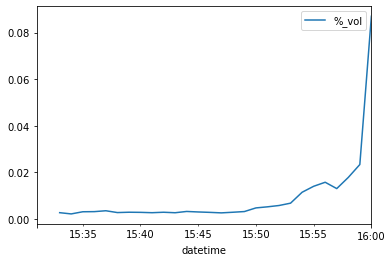

In [137]:
google[filter][['%_vol']].rolling(3).mean().plot()

### ROST

<AxesSubplot:title={'center':'ROST volume of opening 30 mins, 2021-02-11'}, xlabel='datetime'>

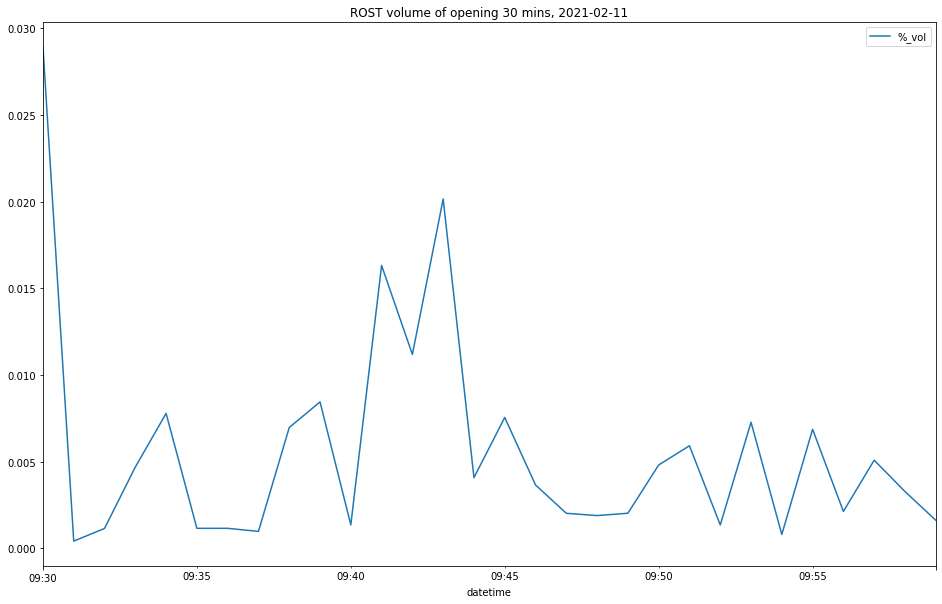

In [158]:
stock = df[df.symbol.isin(['ROST'])]

filter = stock.date.isin(['2021-02-11']) & (stock.time < pd.Timedelta('10:00:00'))
stock[filter][['%_vol']].plot(figsize=(16, 10), title='ROST volume of opening 30 mins, 2021-02-11')

<AxesSubplot:title={'center':'ROST volume of closing 30 mins, 2021-02-11'}, xlabel='datetime'>

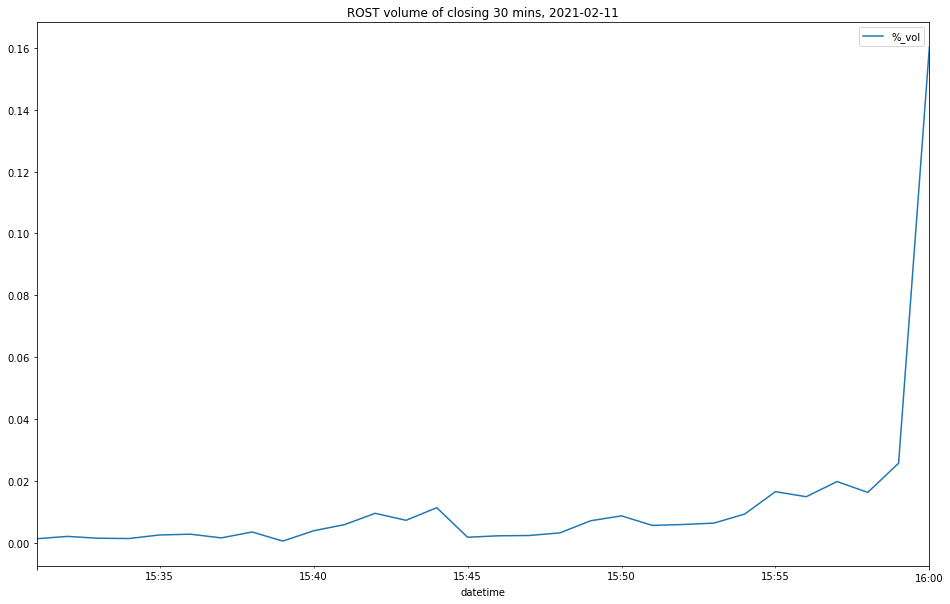

In [159]:
filter = stock.date.isin(['2021-02-11']) & (stock.time > pd.Timedelta('15:30:00'))
stock[filter][['%_vol']].plot(figsize=(16, 10), title='ROST volume of closing 30 mins, 2021-02-11')

In [ ]:
filter = stock.date.isin(['2021-02-11']) & (stock.time > pd.Timedelta('15:30:00'))
stock[filter][['%_vol']].plot(figsize=(16, 10), title='ROST volume of closing 30 mins, 2021-02-11')

### BAN

In [14]:
def generate_u_curve(data):
    '''Generate u_curve based on 180 day average intraday volume'''

    # groupby time to calculate 180-day rolling average volume
    df = data.groupby(data.index.time)['%_vol'].rolling(180).mean()

    # ungroup, then sort df by date and time
    df = df.reset_index()
    df.rename(columns={'level_0': 'time', '%_vol': 'avg_%_vol'}, inplace=True)
    df['date'] = df['datetime'].dt.date
    df = df.sort_values(['date', 'time'], ascending=(True, True)).set_index(['date', 'time'])
    df.drop(columns=['datetime'], inplace=True)

    # convert date from row index to column index
    df = df.unstack().transpose()
    df.index = df.index.droplevel(0)

    return df